In [448]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay,f1_score, classification_report,roc_curve,roc_auc_score

In [449]:
pd.set_option('display.max_columns',None)
pd.set_option('display.width',500)

In [450]:
df = pd.read_csv('./Powerco_clean_data.csv')

In [451]:
df=df.drop(columns=['Unnamed: 0'])
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,start_year,end_year,price_p1_var_year,price_p2_var_year,price_p3_var_year,price_p1_fix_year,price_p2_fix_year,price_p3_fix_year,var_year_price_p1,var_year_price_p2,var_year_price_p3,price_p1_var_6m,price_p2_var_6m,price_p3_var_6m,price_p1_fix_6m,price_p2_fix_6m,price_p3_fix_6m,var_6m_price_p1,var_6m_price_p2,var_6m_price_p3,price_p1_var_3m,price_p2_var_3m,price_p3_var_3m,price_p1_fix_3m,price_p2_fix_3m,price_p3_fix_3m,var_3m_price_p1,var_3m_price_p2,var_3m_price_p3,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,1,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,2013,2016,0.000061,2.627605e-05,0.00044,1.102785,49.550703,22.022535,1.102846,4.955073e+01,22.022975,0.000131,4.100838e-05,0.000908,2.086294,99.530517,44.235794,2.086425,9.953056e+01,44.236702,0.000272,0.000068,0.001816,4.172587,199.061033,88.471588,4.172859,199.061101,88.473404,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,0,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,2009,2016,0.000005,6.089453e-04,0.00000,0.006465,0.000000,0.000000,0.006470,6.089453e-04,0.000000,0.000003,1.217891e-03,0.000000,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,0,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,2010,2016,0.000006,2.558511e-07,0.00000,0.007662,0.000000,0.000000,0.007668,2.558511e-07,0.000000,0.000004,9.450150e-08,0.000000,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [452]:
df_price=pd.read_csv(r'C:\Users\Naila-PC\Downloads\price_data.csv')

Firstly, we are required to focus on  “the difference between off-peak prices in December and January the preceding year”. 

In [453]:
# Group (off-peak) prices by companies and month
monthly_price_by_id = df_price.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# calculate january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [454]:
df=pd.merge(df,diff,on='id')

In [455]:
# We found differences between january and december, but checking  average and maximum diffecences among 
#all periods can help us to get more accurate results and go deep into the research  before making a decision


In [456]:
df_price['mean_dif_price_offpeak_peak_var']=df_price['price_off_peak_var']-df_price['price_peak_var']
df_price['mean_dif_price_offpeak_peak_fix']=df_price['price_off_peak_fix']-df_price['price_peak_fix']
df_price['mean_dif_price_peak_midpeak_var']=df_price['price_peak_var']-df_price['price_mid_peak_var']
df_price['mean_dif_price_peak_midpeak_fix']=df_price['price_peak_fix']-df_price['price_mid_peak_fix']
df_price['mean_dif_price_offpeak_midpeak__var']=df_price['price_off_peak_var']-df_price['price_mid_peak_var']
df_price['mean_dif_price_offpeak_midpeak__fix']=df_price['price_off_peak_fix']-df_price['price_mid_peak_fix']



In [457]:
cols=['id','mean_dif_price_offpeak_peak_var','mean_dif_price_offpeak_peak_fix',
      'mean_dif_price_peak_midpeak_var','mean_dif_price_peak_midpeak_fix','mean_dif_price_offpeak_midpeak__var','mean_dif_price_offpeak_midpeak__fix']
df_price[cols].head()

,id,mean_dif_price_offpeak_peak_var,mean_dif_price_offpeak_peak_fix,mean_dif_price_peak_midpeak_var,mean_dif_price_peak_midpeak_fix,mean_dif_price_offpeak_midpeak__var,mean_dif_price_offpeak_midpeak__fix
0,038af19179925da21a25619c5a24b745,0.151367,44.266931,0.0,0.0,0.151367,44.266931
1,038af19179925da21a25619c5a24b745,0.151367,44.266931,0.0,0.0,0.151367,44.266931
2,038af19179925da21a25619c5a24b745,0.151367,44.266931,0.0,0.0,0.151367,44.266931
3,038af19179925da21a25619c5a24b745,0.149626,44.266931,0.0,0.0,0.149626,44.266931
4,038af19179925da21a25619c5a24b745,0.149626,44.266931,0.0,0.0,0.149626,44.266931


In [458]:
new_mean=df_price[cols].groupby('id').mean().reset_index()
new_mean.head()

,id,mean_dif_price_offpeak_peak_var,mean_dif_price_offpeak_peak_fix,mean_dif_price_peak_midpeak_var,mean_dif_price_peak_midpeak_fix,mean_dif_price_offpeak_midpeak__var,mean_dif_price_offpeak_midpeak__fix
0,0002203ffbb812588b632b9e628cc38d,0.020545,16.280694,0.030633,8.140345,0.051178,24.421038
1,0004351ebdd665e6ee664792efc4fd13,0.146426,44.385450,0.000000,0.000000,0.146426,44.385450
2,0010bcc39e42b3c2131ed2ce55246e3c,0.181558,45.319710,0.000000,0.000000,0.181558,45.319710
3,0010ee3855fdea87602a5b7aba8e42de,0.020465,16.258972,0.029260,8.129484,0.049725,24.388456
4,00114d74e963e47177db89bc70108537,0.147926,44.266930,0.000000,0.000000,0.147926,44.266930


In [459]:
new_max=df_price[cols].groupby('id').max().reset_index()


In [460]:
new_max=new_max.rename(columns={'mean_dif_price_offpeak_peak_var':'max_dif_price_offpeak_peak_var',
                        'mean_dif_price_offpeak_peak_fix':'max_dif_price_offpeak_peak_fix',
                        'mean_dif_price_peak_midpeak_var':'max_dif_price_peak_midpeak_var',
                        'mean_dif_price_peak_midpeak_fix':'max_dif_price_peak_midpeak_fix',
                        'mean_dif_price_offpeak_midpeak__var':'max_dif_price_offpeak_midpeak__var',
                        'mean_dif_price_offpeak_midpeak__fix':'max_dif_price_offpeak_midpeak__fix'})
new_max.head()

,id,max_dif_price_offpeak_peak_var,max_dif_price_offpeak_peak_fix,max_dif_price_peak_midpeak_var,max_dif_price_peak_midpeak_fix,max_dif_price_offpeak_midpeak__var,max_dif_price_offpeak_midpeak__fix
0,0002203ffbb812588b632b9e628cc38d,0.022225,16.291555,0.033743,8.145775,0.055866,24.437330
1,0004351ebdd665e6ee664792efc4fd13,0.148405,44.444710,0.000000,0.000000,0.148405,44.444710
2,0010bcc39e42b3c2131ed2ce55246e3c,0.205742,45.944710,0.000000,0.000000,0.205742,45.944710
3,0010ee3855fdea87602a5b7aba8e42de,0.022581,16.291555,0.031859,8.145775,0.054440,24.437330
4,00114d74e963e47177db89bc70108537,0.149902,44.266931,0.000000,0.000000,0.149902,44.266931


In [461]:
df=pd.merge(df,new_mean,on='id')
df=pd.merge(df,new_max,on='id')

In [462]:
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,start_year,end_year,price_p1_var_year,price_p2_var_year,price_p3_var_year,price_p1_fix_year,price_p2_fix_year,price_p3_fix_year,var_year_price_p1,var_year_price_p2,var_year_price_p3,price_p1_var_6m,price_p2_var_6m,price_p3_var_6m,price_p1_fix_6m,price_p2_fix_6m,price_p3_fix_6m,var_6m_price_p1,var_6m_price_p2,var_6m_price_p3,price_p1_var_3m,price_p2_var_3m,price_p3_var_3m,price_p1_fix_3m,price_p2_fix_3m,price_p3_fix_3m,var_3m_price_p1,var_3m_price_p2,var_3m_price_p3,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,mean_dif_price_offpeak_peak_var,mean_dif_price_offpeak_peak_fix,mean_dif_price_peak_midpeak_var,mean_dif_price_peak_midpeak_fix,mean_dif_price_offpeak_midpeak__var,mean_dif_price_offpeak_midpeak__fix,max_dif_price_offpeak_peak_var,max_dif_price_offpeak_peak_fix,max_dif_price_peak_midpeak_var,max_dif_price_peak_midpeak_fix,max_dif_price_offpeak_midpeak__var,max_dif_price_offpeak_midpeak__fix
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,1,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,2013,2016,0.000061,2.627605e-05,0.00044,1.102785,49.550703,22.022535,1.102846,4.955073e+01,22.022975,0.000131,4.100838e-05,0.000908,2.086294,99.530517,44.235794,2.086425,9.953056e+01,44.236702,0.000272,0.000068,0.001816,4.172587,199.061033,88.471588,4.172859,199.061101,88.473404,1,0.020057,3.700961,0.024038,18.590255,0.034219,7.45067,0.058257,26.040925,0.060550,44.26693,0.085483,8.145775,0.146033,44.26693
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,0,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,2009,2016,0.000005,6.089453e-04,0.00000,0.006465,0.000000,0.000000,0.006470,6.089453e-04,0.000000,0.000003,1.217891e-03,0.000000,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,-0.003767,0.177779,0.142485,44.311375,0.007124,0.00000,0.149609,44.311375,0.151367,44.44471,0.085483,0.000000,0.151367,44.44471
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,0,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,2010,2016,0.000006,2.558511e-07,0.00000,0.007662,0.000000,0.000000,0.007668,2.558511e-07,0.000000,0.000004,9.450150e-08,0.000000,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,-0.004670,0.177779,0.082090,44.385450,0.088421,0.00000,0.170512,44.385450,0.084587,44.44471,0.089162,0.000000,0.172468,44.44471


In [463]:

df['date_renewal'] = pd.to_datetime(df['date_renewal'])



In [464]:
df = df.drop(columns=['date_activ','date_end','date_modif_prod','date_renewal'])

In [465]:
df['channel_sales'].value_counts()

foosdfpfkusacimwkcsosbicdxkicaua    6754
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: channel_sales, dtype: int64

In [466]:
df = pd.get_dummies(df, columns=['channel_sales'],drop_first=True)
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,start_year,end_year,price_p1_var_year,price_p2_var_year,price_p3_var_year,price_p1_fix_year,price_p2_fix_year,price_p3_fix_year,var_year_price_p1,var_year_price_p2,var_year_price_p3,price_p1_var_6m,price_p2_var_6m,price_p3_var_6m,price_p1_fix_6m,price_p2_fix_6m,price_p3_fix_6m,var_6m_price_p1,var_6m_price_p2,var_6m_price_p3,price_p1_var_3m,price_p2_var_3m,price_p3_var_3m,price_p1_fix_3m,price_p2_fix_3m,price_p3_fix_3m,var_3m_price_p1,var_3m_price_p2,var_3m_price_p3,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,mean_dif_price_offpeak_peak_var,mean_dif_price_offpeak_peak_fix,mean_dif_price_peak_midpeak_var,mean_dif_price_peak_midpeak_fix,mean_dif_price_offpeak_midpeak__var,mean_dif_price_offpeak_midpeak__fix,max_dif_price_offpeak_peak_var,max_dif_price_offpeak_peak_fix,max_dif_price_peak_midpeak_var,max_dif_price_peak_midpeak_fix,max_dif_price_offpeak_midpeak__var,max_dif_price_offpeak_midpeak__fix,channel_sales_epumfxlbckeskwekxbiuasklxalciiuu,channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci,channel_sales_fixdbufsefwooaasfcxdxadsiekoceaa,channel_sales_foosdfpfkusacimwkcsosbicdxkicaua,channel_sales_lmkebamcaaclubfxadlmueccxoimlema,channel_sales_sddiedcslfslkckwlfkdpoeeailfpeds,channel_sales_usilxuppasemubllopkaafesmlibmsdf
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,1,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,2013,2016,0.000061,2.627605e-05,0.000440,1.102785,49.550703,22.022535,1.102846,4.955073e+01,22.022975,0.000131,4.100838e-05,9.084737e-04,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,0.000272,0.000068,0.001816,4.172587,199.061033,88.471588,4.172859,199.061101,88.473404,1,0.020057,3.700961,0.024038,18.590255,0.034219,7.450670,0.058257,26.040925,0.060550,44.266930,0.085483,8.145775,0.146033,44.26693,0,0,0,1,0,0,0
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,0,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,2009,2016,0.000005,6.089453e-04,0.000000,0.006465,0.000000,0.000000,0.006470,6.089453e-04,0.000000,0.000003,1.217891e-03,0.000000e+00,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,-0.003767,0.177779,0.142485,44.311375,0.007124,0.000000,0.149609,44.311375,0.151367,44.444710,0.085483,0.000000,0.151367,44.44471,0,0,0,0,0,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,0,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,2010,2016,0.000006,2.558511e-07,0.000000,0.007662,0.000000,0.000000,0.007668,2.558511e-07,0.000000,0.000004,9.450150e-08,0.000000e+00,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,-0.004670,0.177779,0.082090,44.385450,0.088421,0.000000,0.170512,44.385450,0.084587,44.444710,0.089162,0.000000,0.172468,44.44471,0,0,0,1,0,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,0,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,2010,2016,0.000005,0.000000e+00,0.000000,0.006465,0.000000,0.000000,0.006470,0.000000e+00,0.000000,0.000003,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,-0.004547,0.177779,0.151210,44.400265,0.000000,0.000000,0.151210,44.400265,0.153133,44.444710,0.000000,0.000000,0.153133,44.44471,0,0,0,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.11

In [467]:
# in channel_sales column ,frequency of some values is lower ,therefore, beacuse of low frequency i will delete them
df = df.drop(columns=['channel_sales_fixdbufsefwooaasfcxdxadsiekoceaa', 'channel_sales_epumfxlbckeskwekxbiuasklxalciiuu',
                      'channel_sales_sddiedcslfslkckwlfkdpoeeailfpeds','channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci'])


In [468]:
df['origin_up'].value_counts()

lxidpiddsbxsbosboudacockeimpuepw    7097
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: origin_up, dtype: int64

In [469]:
df = pd.get_dummies(df, columns=['origin_up'],drop_first=True)
df.head(3)

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,start_year,end_year,price_p1_var_year,price_p2_var_year,price_p3_var_year,price_p1_fix_year,price_p2_fix_year,price_p3_fix_year,var_year_price_p1,var_year_price_p2,var_year_price_p3,price_p1_var_6m,price_p2_var_6m,price_p3_var_6m,price_p1_fix_6m,price_p2_fix_6m,price_p3_fix_6m,var_6m_price_p1,var_6m_price_p2,var_6m_price_p3,price_p1_var_3m,price_p2_var_3m,price_p3_var_3m,price_p1_fix_3m,price_p2_fix_3m,price_p3_fix_3m,var_3m_price_p1,var_3m_price_p2,var_3m_price_p3,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,mean_dif_price_offpeak_peak_var,mean_dif_price_offpeak_peak_fix,mean_dif_price_peak_midpeak_var,mean_dif_price_peak_midpeak_fix,mean_dif_price_offpeak_midpeak__var,mean_dif_price_offpeak_midpeak__fix,max_dif_price_offpeak_peak_var,max_dif_price_offpeak_peak_fix,max_dif_price_peak_midpeak_var,max_dif_price_peak_midpeak_fix,max_dif_price_offpeak_midpeak__var,max_dif_price_offpeak_midpeak__fix,channel_sales_foosdfpfkusacimwkcsosbicdxkicaua,channel_sales_lmkebamcaaclubfxadlmueccxoimlema,channel_sales_usilxuppasemubllopkaafesmlibmsdf,origin_up_ewxeelcelemmiwuafmddpobolfuxioce,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw,origin_up_usapbepcfoloekilkwsdiboslwaxobdp
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,1,0.0,25.44,25.44,2,678.99,3,43.648,2013,2016,0.000061,2.627605e-05,0.00044,1.102785,49.550703,22.022535,1.102846,4.955073e+01,22.022975,0.000131,4.100838e-05,0.000908,2.086294,99.530517,44.235794,2.086425,9.953056e+01,44.236702,0.000272,0.000068,0.001816,4.172587,199.061033,88.471588,4.172859,199.061101,88.473404,1,0.020057,3.700961,0.024038,18.590255,0.034219,7.45067,0.058257,26.040925,0.060550,44.26693,0.085483,8.145775,0.146033,44.26693,1,0,0,0,0,0,1,0
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,0,0.0,16.38,16.38,1,18.89,6,13.800,2009,2016,0.000005,6.089453e-04,0.00000,0.006465,0.000000,0.000000,0.006470,6.089453e-04,0.000000,0.000003,1.217891e-03,0.000000,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,-0.003767,0.177779,0.142485,44.311375,0.007124,0.00000,0.149609,44.311375,0.151367,44.44471,0.085483,0.000000,0.151367,44.44471,0,0,0,0,1,0,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,0,0.0,28.60,28.60,1,6.60,6,13.856,2010,2016,0.000006,2.558511e-07,0.00000,0.007662,0.000000,0.000000,0.007668,2.558511e-07,0.000000,0.000004,9.450150e-08,0.000000,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,-0.004670,0.177779,0.082090,44.385450,0.088421,0.00000,0.170512,44.385450,0.084587,44.44471,0.089162,0.000000,0.172468,44.44471,1,0,0,0,1,0,0,0


In [470]:
df = df.drop(columns=['origin_up_usapbepcfoloekilkwsdiboslwaxobdp','origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])


In previous task, I mentioned that some features are highly skewed and there are a lot of outliers.In general,tree-based models(they are non-parametric),also Random Forests are considered to be insensitive to data skewness and no need to solve skewness problem.I am going to use Log transformation, in this case Standardization just makes the feature zero-mean and unit variance. It's just a linear transform, and it doesn't decrease the skewness.Log transformation is a common technique used to reduce skewness in a distribution and make it more symmetric.

In [471]:
# i wnow skewed featues from the charts  in pervious task 

df['cons_12m'] = np.log10(df['cons_12m']+1)
df['cons_gas_12m'] = np.log10(df['cons_gas_12m']+1)
df['cons_last_month'] = np.log10(df['cons_last_month']+1)
df['imp_cons'] = np.log10(df['imp_cons']+1)
df['forecast_cons_12m'] = np.log10(df['forecast_cons_12m']+1)
df['forecast_cons_year'] = np.log10(df['forecast_cons_year']+1)
df['forecast_price_pow_off_peak'] = np.log10(df['forecast_price_pow_off_peak']+1)



In [472]:
df.head(3)

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,start_year,end_year,price_p1_var_year,price_p2_var_year,price_p3_var_year,price_p1_fix_year,price_p2_fix_year,price_p3_fix_year,var_year_price_p1,var_year_price_p2,var_year_price_p3,price_p1_var_6m,price_p2_var_6m,price_p3_var_6m,price_p1_fix_6m,price_p2_fix_6m,price_p3_fix_6m,var_6m_price_p1,var_6m_price_p2,var_6m_price_p3,price_p1_var_3m,price_p2_var_3m,price_p3_var_3m,price_p1_fix_3m,price_p2_fix_3m,price_p3_fix_3m,var_3m_price_p1,var_3m_price_p2,var_3m_price_p3,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,mean_dif_price_offpeak_peak_var,mean_dif_price_offpeak_peak_fix,mean_dif_price_peak_midpeak_var,mean_dif_price_peak_midpeak_fix,mean_dif_price_offpeak_midpeak__var,mean_dif_price_offpeak_midpeak__fix,max_dif_price_offpeak_peak_var,max_dif_price_offpeak_peak_fix,max_dif_price_peak_midpeak_var,max_dif_price_peak_midpeak_fix,max_dif_price_offpeak_midpeak__var,max_dif_price_offpeak_midpeak__fix,channel_sales_foosdfpfkusacimwkcsosbicdxkicaua,channel_sales_lmkebamcaaclubfxadlmueccxoimlema,channel_sales_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.0,0.000000,0.0,0.0,1.78,0.114481,0.098142,1.619163,1,0.0,25.44,25.44,2,678.99,3,43.648,2013,2016,0.000061,2.627605e-05,0.00044,1.102785,49.550703,22.022535,1.102846,4.955073e+01,22.022975,0.000131,4.100838e-05,0.000908,2.086294,99.530517,44.235794,2.086425,9.953056e+01,44.236702,0.000272,0.000068,0.001816,4.172587,199.061033,88.471588,4.172859,199.061101,88.473404,1,0.020057,3.700961,0.024038,18.590255,0.034219,7.45067,0.058257,26.040925,0.060550,44.26693,0.085483,8.145775,0.146033,44.26693,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.0,2.280920,0.0,0.0,16.27,0.145711,0.000000,1.656207,0,0.0,16.38,16.38,1,18.89,6,13.800,2009,2016,0.000005,6.089453e-04,0.00000,0.006465,0.000000,0.000000,0.006470,6.089453e-04,0.000000,0.000003,1.217891e-03,0.000000,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,-0.003767,0.177779,0.142485,44.311375,0.007124,0.00000,0.149609,44.311375,0.151367,44.44471,0.085483,0.000000,0.151367,44.44471,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.0,1.689841,0.0,0.0,38.72,0.165794,0.087899,1.656207,0,0.0,28.60,28.60,1,6.60,6,13.856,2010,2016,0.000006,2.558511e-07,0.00000,0.007662,0.000000,0.000000,0.007668,2.558511e-07,0.000000,0.000004,9.450150e-08,0.000000,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,-0.004670,0.177779,0.082090,44.385450,0.088421,0.00000,0.170512,44.385450,0.084587,44.44471,0.089162,0.000000,0.172468,44.44471,1,0,0,1,0,0


In [473]:
pd.DataFrame(df.isnull().sum()).T

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,start_year,end_year,price_p1_var_year,price_p2_var_year,price_p3_var_year,price_p1_fix_year,price_p2_fix_year,price_p3_fix_year,var_year_price_p1,var_year_price_p2,var_year_price_p3,price_p1_var_6m,price_p2_var_6m,price_p3_var_6m,price_p1_fix_6m,price_p2_fix_6m,price_p3_fix_6m,var_6m_price_p1,var_6m_price_p2,var_6m_price_p3,price_p1_var_3m,price_p2_var_3m,price_p3_var_3m,price_p1_fix_3m,price_p2_fix_3m,price_p3_fix_3m,var_3m_price_p1,var_3m_price_p2,var_3m_price_p3,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,mean_dif_price_offpeak_peak_var,mean_dif_price_offpeak_peak_fix,mean_dif_price_peak_midpeak_var,mean_dif_price_peak_midpeak_fix,mean_dif_price_offpeak_midpeak__var,mean_dif_price_offpeak_midpeak__fix,max_dif_price_offpeak_peak_var,max_dif_price_offpeak_peak_fix,max_dif_price_peak_midpeak_var,max_dif_price_peak_midpeak_fix,max_dif_price_offpeak_midpeak__var,max_dif_price_offpeak_midpeak__fix,channel_sales_foosdfpfkusacimwkcsosbicdxkicaua,channel_sales_lmkebamcaaclubfxadlmueccxoimlema,channel_sales_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [474]:
df=df.dropna(axis=1)

In [475]:
df.isnull().sum().sum()

0

In [476]:
X=df.drop(columns=['churn','id'])
y=df['churn']

In [477]:
X.shape

(14606, 58)

In [478]:
y.shape

(14606,)

C:\Users\Naila-PC\AppData\Local\Temp\ipykernel_3324\3894043846.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correl=df.corr()


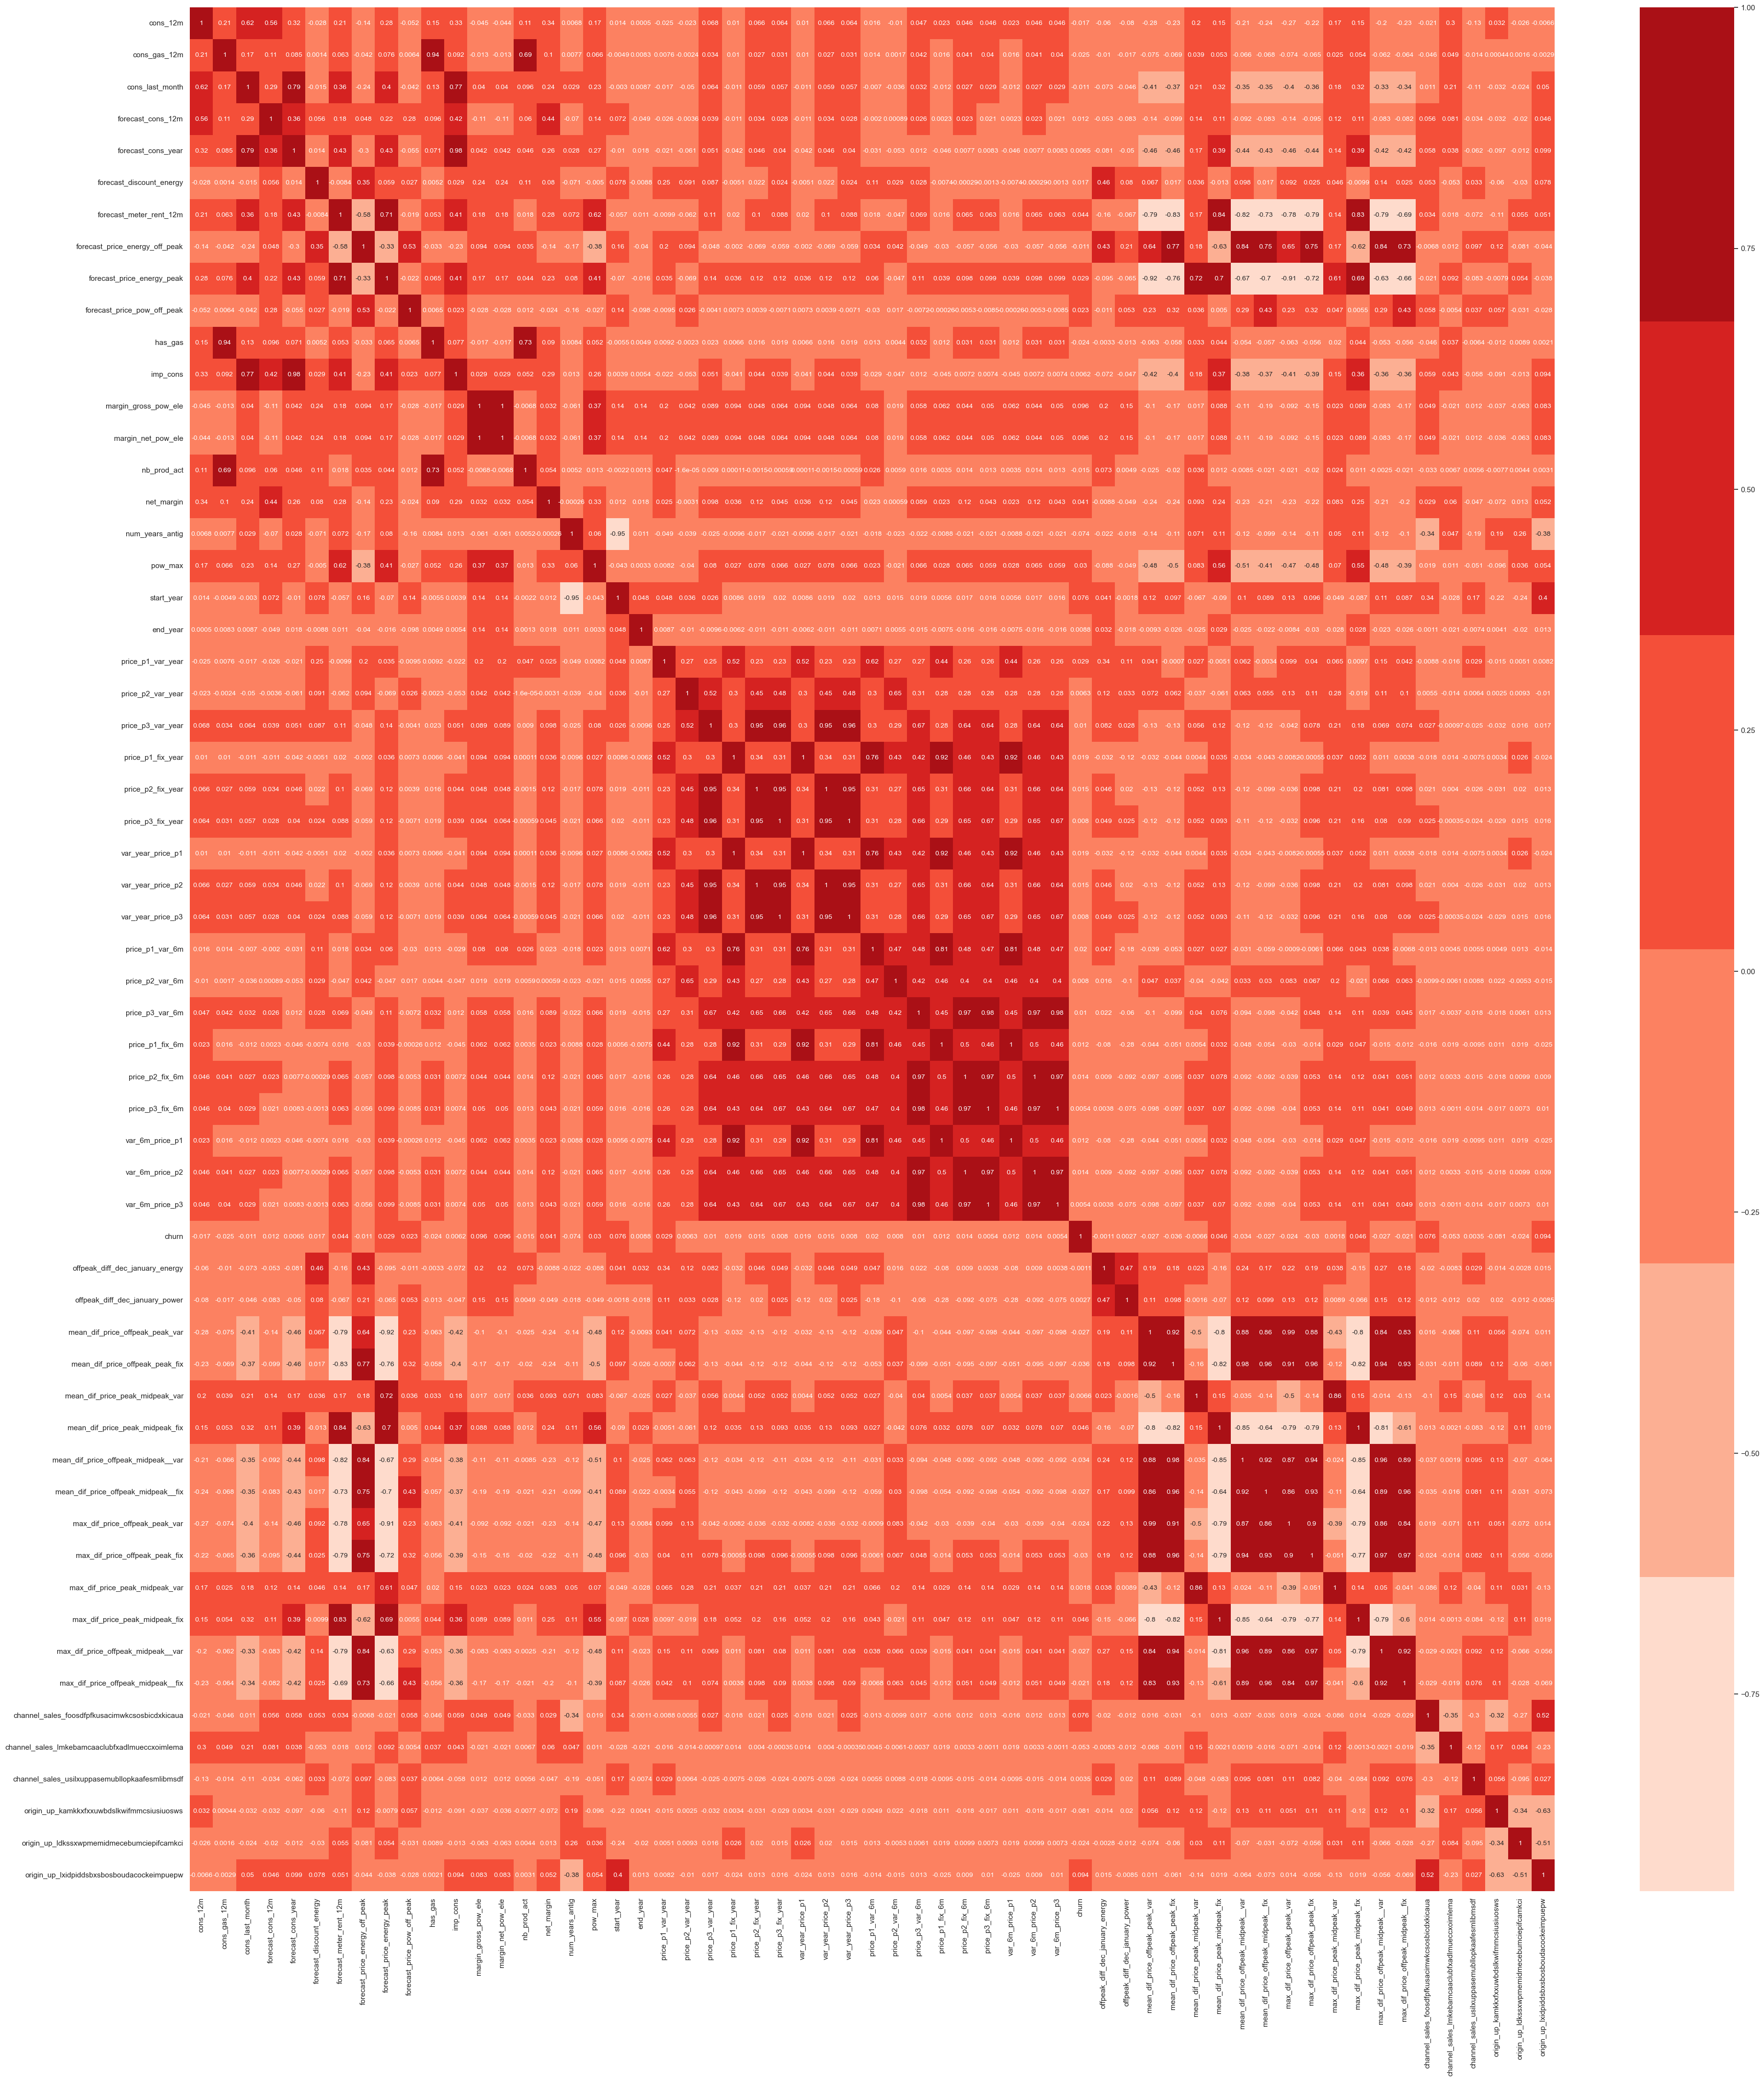

In [479]:
correl=df.corr()
plt.figure(figsize=(45,50))
colormap = sns.color_palette("Reds")
sns.heatmap(correl,annot=True,annot_kws={"size":10},cmap=colormap)
plt.show()

In [480]:
X.columns

Index(['cons_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy', 'forecast_meter_rent_12m', 'forecast_price_energy_off_peak', 'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas', 'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act', 'net_margin', 'num_years_antig', 'pow_max', 'start_year', 'end_year', 'price_p1_var_year', 'price_p2_var_year', 'price_p3_var_year', 'price_p1_fix_year',
       'price_p2_fix_year', 'price_p3_fix_year', 'var_year_price_p1', 'var_year_price_p2', 'var_year_price_p3', 'price_p1_var_6m', 'price_p2_var_6m', 'price_p3_var_6m', 'price_p1_fix_6m', 'price_p2_fix_6m', 'price_p3_fix_6m', 'var_6m_price_p1', 'var_6m_price_p2', 'var_6m_price_p3', 'offpeak_diff_dec_january_energy', 'offpeak_diff_dec_january_power', 'mean_dif_price_offpeak_peak_var', 'mean_dif_price_offpeak_peak_fix', 'mean_dif_price_peak_midpeak_var', 'mean_dif_price_peak_midpeak_fix',
       'mean_dif_price_

In [481]:
# delete highly correlated features (one of both) but  if utilize random forest model it will not be affected by multicollinearity
X = X.drop(columns=['forecast_cons_year','num_years_antig'])

In [482]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=51)


In [483]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [484]:
predictions=rf.predict(X_test)

In [485]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [486]:
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

True positives: 20
False positives: 2
True negatives: 3304
False negatives: 326



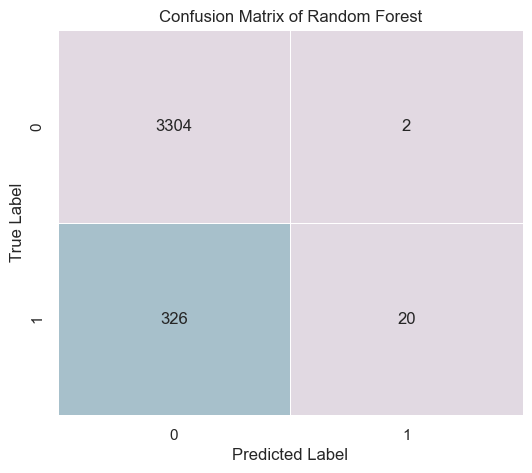

In [487]:
cm = confusion_matrix(y_test, predictions, labels=rf.classes_)
sns.set(font_scale=1)
plt.subplots(figsize=(6,5))
sns.heatmap(cm,annot=True,cbar=False,cmap='twilight',linewidth=0.5,fmt='d')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix of Random Forest');

In [488]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3306
           1       0.91      0.06      0.11       346

    accuracy                           0.91      3652
   macro avg       0.91      0.53      0.53      3652
weighted avg       0.91      0.91      0.87      3652



In [489]:
print(f"Accuracy: {round(accuracy_score(y_test, predictions),2)}")
print(f"Precision: {round(precision_score(y_test, predictions),2)}")
print(f"Recall: {round(recall_score(y_test, predictions),2)}")
print(f"f1 score: {round(f1_score(y_test, predictions),2)}")

Accuracy: 0.91
Precision: 0.91
Recall: 0.06
f1 score: 0.11


The other most commonly used ways to measure model performance is the Receiver Operating Characteristic curve (ROC),which shows the false positive rate (customers that stay the model incorrectly identify as leaving) on the x-axis and the true positive rate (customers the model correctly identify as leaving) on the y-axis.The closer the curve reaching point 1 on the top left of the curve, the better the model is since we maximize correct predictions and minimize incorrect ones

In [490]:
proba_predictions = rf.predict_proba(X_test)

In [491]:
fpr, tpr, thresh = roc_curve(y_test, proba_predictions[:,1], pos_label=1)

In [492]:
auc_score = roc_auc_score(y_test, proba_predictions[:,1])
print('Auc Score:',round(auc_score,2))

Auc Score: 0.67


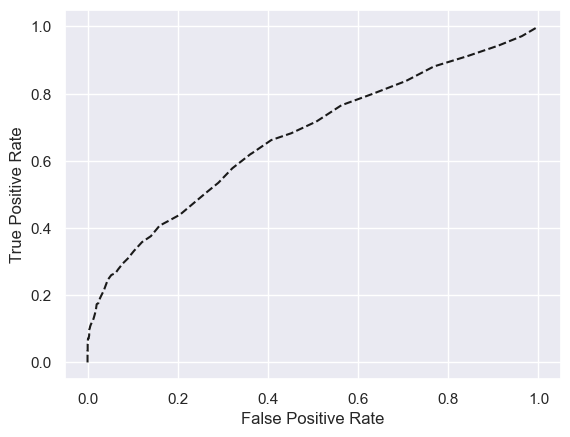

In [493]:
plt.plot(fpr, tpr, linestyle='--',color='k', label='AUC = %0.4f' %auc_score)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

As I mentioned before ,churn data is imbalanced and to evaluate the performance of our model accuracy is not enough.So, I also checked f1 score,precision and recall metrics and got interesting results. Although precision metric is looking great, recall is lower than it. When we look at our confusion matrix visualization we see that there are total 3306 Negatives and we predicted 3305 correctly.But We  predicted only 19 Positive samples correctly and it is very poor result,therefore the recall metric is low and we need to focus on it.

In [494]:
feature_impor = pd.DataFrame(data={'name':X.columns, 'feature_importance':[0]*len(X.columns)})
feature_impor['feature_importance'] = feature_impor['feature_importance'] + (rf.feature_importances_)

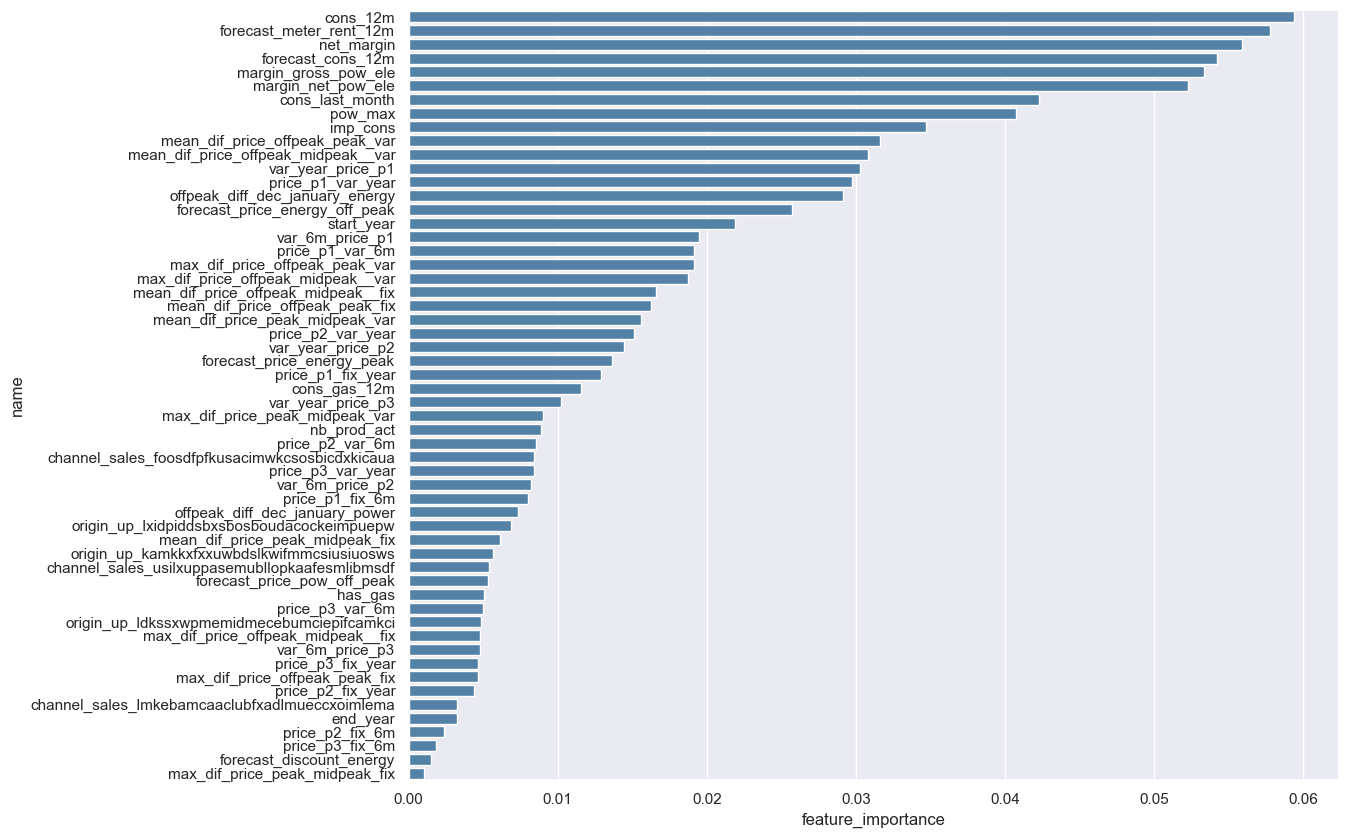

In [495]:
plt.figure(figsize=(12,10))
ax = sns.barplot(data=feature_impor.sort_values(by=['feature_importance'], 
                                                        ascending=False), y='name', x='feature_importance',color='steelblue')

According to the horizontal bar chart above,consumption for 12 months and margin features have big impact on this model. Some features that we created also have influential factor

In [496]:
probabilities = proba_predictions[:, 1]
X_test = X_test.reset_index()
X_test.drop(columns='index', inplace=True)
X_test['churn'] = predictions.tolist()
X_test['churn_probability'] = probabilities.tolist()
X_test.to_csv('predictions_data.csv')

In [497]:
df.to_csv('new_data.csv')